In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skyfield.sgp4lib import EarthSatellite
import skyfield.api
import datetime

In [21]:
fs = 10000
start = 1240 # seconds
end = 1770 # seconds

def open_file(path):
    with open(path, 'rb') as f:
        f.seek(start * fs * 8)
        return np.fromfile(f, dtype = 'complex64', count = (end-start) * fs)
    
chan0 = open_file('/home/daniel/aoa_nayif1_chan0.c64')
chan1 = open_file('/home/daniel/aoa_nayif1_chan1.c64')

In [25]:
average = fs//10
corr = chan0 * np.conj(chan1)
(1e3*corr).astype('complex64').tofile('/tmp/corr.complex64')
corr = np.sum(corr[:corr.size//average*average].reshape((-1,average)), axis = 1)
pwr_average_0 = np.sum(np.abs(chan0**2)[:chan0.shape[0]//average*average].reshape((-1,average)), axis = 1)
pwr_average_1 = np.sum(np.abs(chan1**2)[:chan1.shape[0]//average*average].reshape((-1,average)), axis = 1)

In [31]:
tle = """NAYIF-1 (EO-88)         
1 42017U 17008BX  19117.74496541  .00001148  00000-0  48345-4 0  9991
2 42017  97.4069 185.3673 0006167   9.1843 350.9506 15.25366176122004"""
sat = EarthSatellite(tle.split('\n')[1], tle.split('\n')[2])
sat

<EarthSatellite number=42017 epoch=2019-04-27T17:52:45Z>

In [32]:
groundstation = skyfield.api.Topos(latitude = 40.468671, longitude = -4.085638, elevation_m = 800)

In [33]:
recording_start_time = np.datetime64('2019-04-28T09:48:40.565206')
file_start_time = recording_start_time + start * np.timedelta64(1, 's')
sample_time = file_start_time + np.arange(corr.size)/corr.size * (end - start) * 1e9 * np.timedelta64(1,'ns')

In [34]:
ts = skyfield.api.load.timescale()

In [35]:
timestamps = (sample_time - np.datetime64('1970-01-01T00:00:00'))/np.timedelta64(1, 's')
times_skyfield = ts.utc([datetime.datetime.utcfromtimestamp(t).replace(tzinfo = skyfield.api.utc) for t in timestamps])

In [36]:
obs = (sat - groundstation).at(times_skyfield)

In [37]:
alt, az, distance = obs.altaz()

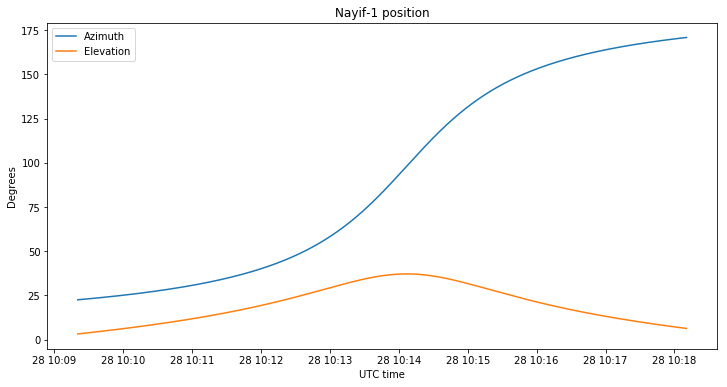

In [38]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(sample_time, az.degrees)
plt.plot(sample_time, alt.degrees)
plt.legend(['Azimuth', 'Elevation'])
plt.title('Nayif-1 position')
plt.xlabel('UTC time')
plt.ylabel('Degrees');

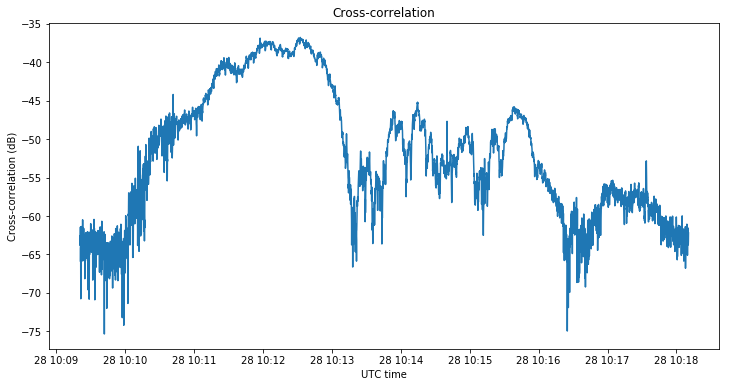

In [39]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(sample_time, 10*np.log10(np.abs(corr)))
plt.title('Cross-correlation')
plt.xlabel('UTC time')
plt.ylabel('Cross-correlation (dB)');

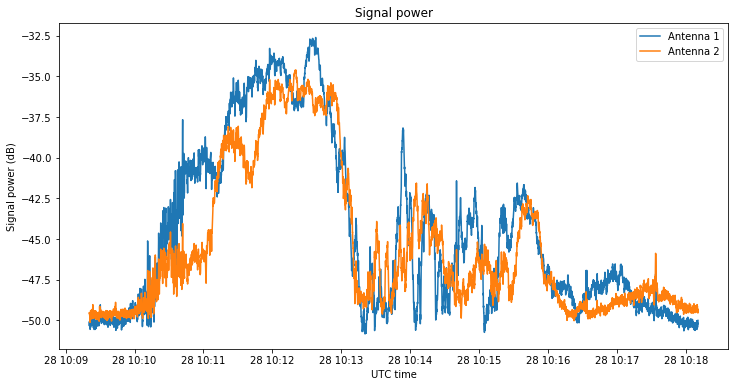

In [41]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(sample_time, 10*np.log10(pwr_average_0))
plt.plot(sample_time, 10*np.log10(pwr_average_1)+5)
plt.legend(['Antenna 1', 'Antenna 2'])
plt.title('Signal power')
plt.xlabel('UTC time')
plt.ylabel('Signal power (dB)');

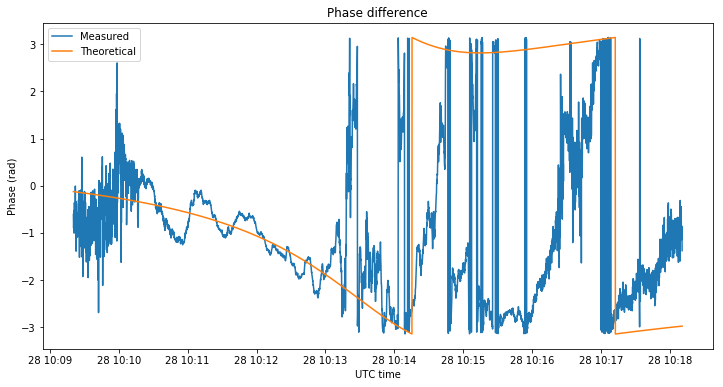

In [18]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(sample_time, np.angle(corr))
theta = np.sin(np.deg2rad(35-az.degrees))*np.cos(alt.radians)*np.pi-0.8
theta = (theta + np.pi) % (2*np.pi) - np.pi
plt.plot(sample_time, theta)
plt.title('Phase difference')
plt.legend(['Measured', 'Theoretical'])
plt.xlabel('UTC time')
plt.ylabel('Phase (rad)');